In [1]:
from lib import price_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
reload(price_utils)
pd.options.display.float_format = '{:,.2f}'.format

months = ['2015-10-01','2015-11-01','2015-12-01',
          '2016-01-01','2016-02-01','2016-03-01',
          '2016-04-01','2016-05-01','2016-06-01',
          '2016-07-01','2016-08-01','2016-09-01']

### Get all data from BigQuery
**Needs to be done manually as tables are too big to export**

### Import data from BigQuery following manual queries and combining

In [2]:
csv0 = pd.read_csv('data/ppd_15_10_to_16_09_0~')
csv1 = pd.read_csv('data/ppd_15_10_to_16_09_1~')
totals = pd.concat([csv0,csv1])

### Total possible savings

In [4]:
print totals['possible_savings'].sum()

410354642.49


In [6]:
table = {}
i=0
for p in [1, 50, 100, 500, 1000]:
    temp = totals['possible_savings'][totals['possible_savings'] > p]
    table[i] = [
        "Savings over £" + str(p) + "/practice/month",
        "£%s" % "{:,.0f}".format(temp.sum()),
        "%s" % "{:,.0f}".format(len(temp)),
        "£%s" % "{:,.0f}".format(temp.median())]
    i +=1
pd.DataFrame.from_dict(table, orient='index').reset_index().sort_values('index')

,index,0,1,2,3
0,0,Savings over £1/practice/month,"£410,354,642","14,274,013",£8
1,1,Savings over £50/practice/month,"£273,485,140","2,035,124",£92
2,2,Savings over £100/practice/month,"£193,696,740","905,352",£159
3,3,Savings over £500/practice/month,"£34,990,730","41,362",£655
4,4,Savings over £1000/practice/month,"£12,736,998","7,283","£1,342"


In [5]:
totals.loc[(totals.possible_savings > 1000)].describe()

,quantity,possible_savings,cum_sum
count,"7,283.00","7,283.00","7,283.00"
mean,"3,302.70","1,748.87",8.09
std,"23,027.95","1,264.90",3.20
min,0.00,"1,000.04",0.02
25%,200.00,"1,125.04",5.74
50%,600.00,"1,341.71",8.58
75%,"1,653.50","1,879.86",10.82
max,"709,173.00","23,304.06",12.74


### Figure 1
    run generic switching notebook first as combines data from that

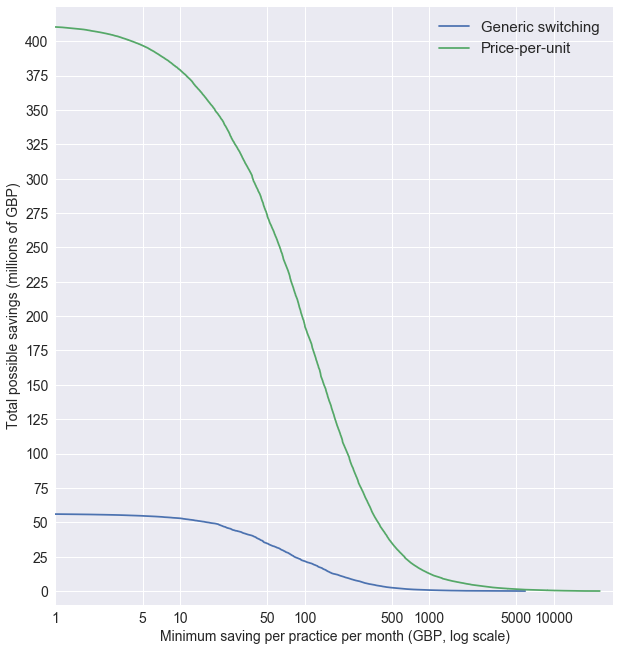

In [3]:
totals.sort_values('possible_savings', inplace=True, ascending=False)

totals['cum_sum'] = totals['possible_savings'].cumsum()/1000000

fig, ax = plt.subplots(figsize=(10, 11))
generic_comp = pd.read_csv('graph.csv')
ax.plot(generic_comp['hypothetical_saving_10c'],
        generic_comp['cum_sum'],
        label='Generic switching')

ax.plot(totals['possible_savings'],
        totals['cum_sum'],
        label='Price-per-unit')

ax.yaxis.set_ticks(range(0,425,25))
ax.set_xscale("log")
ax.xaxis.set_ticks([1,5,10,50,100,500,1000,5000,10000])
ax.set_xlim(1,30000)
ax.set_ylim(-10,425)
ax.set_xlabel('Minimum saving per practice per month (GBP, log scale)')
ax.set_ylabel('Total possible savings (millions of GBP)')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%0.0f'))
ax.legend(fontsize=15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

### Figure 2(b)

7739
8180


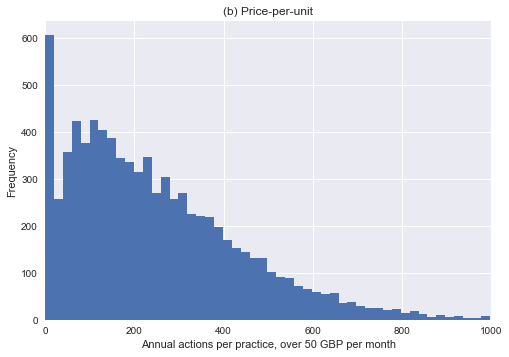

,(b) Price-per-unit
count,"8,180.00"
mean,248.79
std,195.03
min,0.00
5%,0.00
50%,209.00
95%,620.00
max,"2,284.00"


In [7]:
practices = pd.read_csv('data/practices_4.csv')
df_hist = totals.loc[totals.possible_savings>50].groupby('practice').size()
df_hist = df_hist.to_frame(name='(b) Price-per-unit')
print len(df_hist)
df_hist = df_hist.merge(practices, how='right', left_index=True, right_on='practice')
df_hist = df_hist.fillna(0)
print len(df_hist)

df_hist.loc[df_hist['(b) Price-per-unit']<1000].hist(bins=50)
plt.xlim(0,1000)
#plt.ylim(0,1395)
plt.xlabel('Annual actions per practice, over 50 GBP per month')
plt.ylabel('Frequency')
plt.show()

df_hist.describe(percentiles=[.05,.5,.95])

### Number of practices with no actions

In [8]:
len(df_hist.loc[df_hist['(b) Price-per-unit']==0])

441

### Figure 3

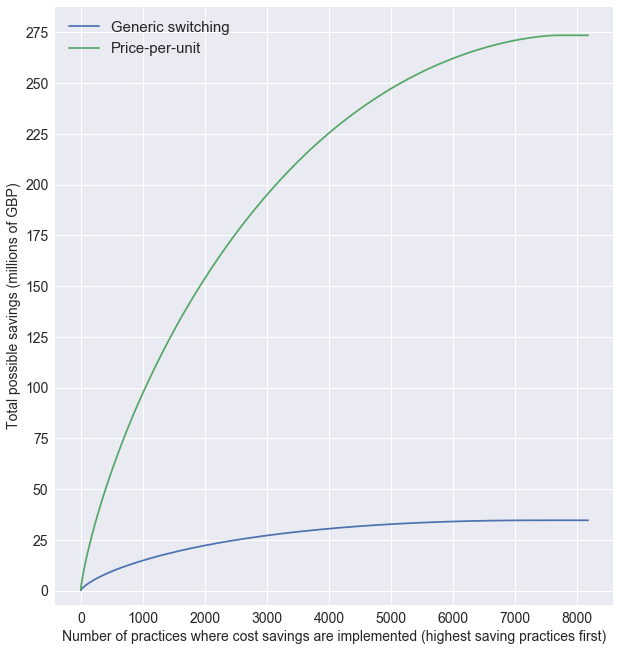

In [9]:
sums = totals.loc[totals.possible_savings>50].groupby('practice').sum()
sums = sums.merge(practices, how='right', left_index=True, right_on='practice')
sums = sums.fillna(0)
sums.sort_values('possible_savings', inplace=True, ascending=False)

sums['cum_sum2'] = sums['possible_savings'].cumsum()/1000000


fig, ax = plt.subplots(figsize=(10, 11))
generic_comp = pd.read_csv('graph2.csv')
ax.plot(range(len(sums)),
        generic_comp['cum_sum2'],
        label='Generic switching')

ax.plot(range(len(sums)),
        sums['cum_sum2'],
        label='Price-per-unit')

ax.yaxis.set_ticks(range(0,425,25))
#ax.set_xscale("log")
#ax.xaxis.set_ticks([1,5,10,50,100,500,1000,5000,10000])
#ax.set_xlim(1,30000)
ax.set_ylim(-7,287.5)
ax.set_xlabel('Number of practices where cost savings are implemented (highest saving practices first)')
ax.set_ylabel('Total possible savings (millions of GBP)')
#plt.set_yscale("log")
#ax.set_title('(c) minimising cost-per-unit',loc='left')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%0.0f'))
ax.legend(fontsize=15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

In [10]:
generic_comp.cum_sum2.describe()

count   8,180.00
mean       27.12
std         8.65
min         0.11
25%        22.48
50%        30.73
75%        34.15
max        34.63
Name: cum_sum2, dtype: float64

In [11]:
sums.cum_sum2.describe()

count   8,180.00
mean      201.81
std        72.57
min         0.63
25%       155.89
50%       227.58
75%       263.62
max       273.49
Name: cum_sum2, dtype: float64